In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sci = pd.read_csv("D:\\2024_S1\\ML_SEP_2402\\Final_update\\sci_20100101_20251113.csv")
ftp = pd.read_csv("D:\\2024_S1\\ML_SEP_2402\\Final_update\\ftp_20100101_20251115.csv")
ssw = pd.read_csv("D:\\2024_S1\\ML_SEP_2402\\Final_update\\ssw_20100101_20251115.csv")   

In [3]:
sci.rename(columns={'start time':'start_time', 'end time':'end_time',
                    'peak time':'peak_time',
                    'fl_class': 'label'}, inplace=True)

In [4]:
sci['cls'] = sci['label'].apply(lambda x: str(x)[0])

In [5]:
sci['start_time'] = pd.to_datetime(sci['start_time'])
ftp['start_time'] = pd.to_datetime(ftp['start_time'], format='mixed')
ssw['start_time'] = pd.to_datetime(ssw['start_time'], format='mixed')
sci['peak_time'] = pd.to_datetime(sci['peak_time'], format='mixed')
ftp['peak_time'] = pd.to_datetime(ftp['peak_time'], format='mixed')
ssw['peak_time'] = pd.to_datetime(ssw['peak_time'], format='mixed')

In [ ]:
#for i in range(len(ftp)):
    #try:
        #ftp.at[i, 'peak_time'] = pd.to_datetime(ftp.at[i, 'peak_time'], format='mixed')
    #except:
        #ftp.at[i, 'peak_time'] = None

In [ ]:
#ftp = ftp[ftp['peak_time'].notnull()].reset_index(drop=True)

In [ ]:
#ftp.to_csv('ftp_20100101_20251115.csv')

In [6]:
sci = sci[sci['start_time'] <= '2024-12-31'].reset_index(drop=True)
ftp = ftp[ftp['start_time'] <= '2024-12-31'].reset_index(drop=True)
ssw = ssw[ssw['start_time'] <= '2024-12-31'].reset_index(drop=True)

In [7]:
len(sci), len(ftp), len(ssw)

(33215, 27586, 33489)

In [55]:
sci.groupby('cls').size()

cls
B    11372
C    19207
M     2497
X      139
dtype: int64

In [53]:
ftp.groupby('cls').size()

cls
A       98
B     9120
C    16049
M     2193
X      126
dtype: int64

In [8]:
ssw.drop(columns=['cls'], inplace=True)
ssw['cls'] = ssw['label'].apply(lambda x: str(x)[0])

In [9]:
ssw.groupby('cls').size()

cls
A     1357
B    10023
C    19791
M     2194
X      124
dtype: int64

In [10]:
def get_log10_intensity(label):
    # Turn class to continuous log intensity.
    # input: flare intensity in the form of CLASS+level, e.g. 'M1.8'
    # output: log10(flare intensity)
    c = label[0]
    intensity = float(label[1:])
    if c == 'B':
        return np.log10(intensity * 10 ** -7)
    elif c == 'C':
        return np.log10(intensity * 10 ** -6)
    elif c == 'M':
        return np.log10(intensity * 10 ** -5)
    elif c == 'A':
        return np.log10(intensity * 10 ** -8)
    else:
        return np.log10(intensity * 10 ** -4)

In [11]:
sci['log_intensity'] = sci['label'].apply(get_log10_intensity)

In [12]:
ftp['log_intensity'] = ftp['label'].apply(get_log10_intensity)
ssw['log_intensity'] = ssw['label'].apply(get_log10_intensity)

C:\Users\huke0\AppData\Local\Temp\ipykernel_11748\2349128524.py:14: RuntimeWarning: divide by zero encountered in log10
  return np.log10(intensity * 10 ** -8)


In [13]:
ftp = ftp[ftp['log_intensity'] >= -8.0]

(array([  337.,  1004.,  3221.,  6686., 12500.,  7296.,  1851.,   456.,
          116.,    22.]),
 array([-8.        , -7.50315171, -7.00630341, -6.50945512, -6.01260682,
        -5.51575853, -5.01891023, -4.52206194, -4.02521364, -3.52836535,
        -3.03151705]),
 <BarContainer object of 10 artists>)

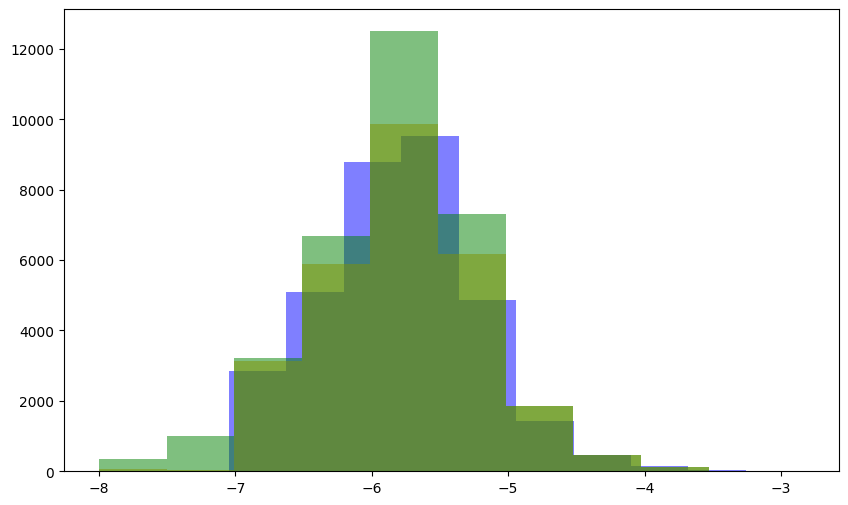

In [70]:
plt.figure(figsize=(10,6))
plt.hist(sci['log_intensity'], alpha=0.5, label='sci', color='blue')
plt.hist(ftp['log_intensity'], alpha=0.5, label='ftp', color='orange')
plt.hist(ssw['log_intensity'], alpha=0.5, label='ssw', color='green')

In [14]:
# For ftp and ssw, before 2019-12-07, add log(0.7) to log_intensity

ftp['adjusted_log_intensity'] = ftp['log_intensity'].copy()
ssw['adjusted_log_intensity'] = ssw['log_intensity'].copy()

ftp.loc[ftp['start_time'] < '2019-12-07', 'adjusted_log_intensity'] -= np.log10(0.7)
ssw.loc[ssw['start_time'] < '2019-12-07', 'adjusted_log_intensity'] -= np.log10(0.7)

Text(0.5, 1.0, 'Comparison of Flare Intensity Distributions')

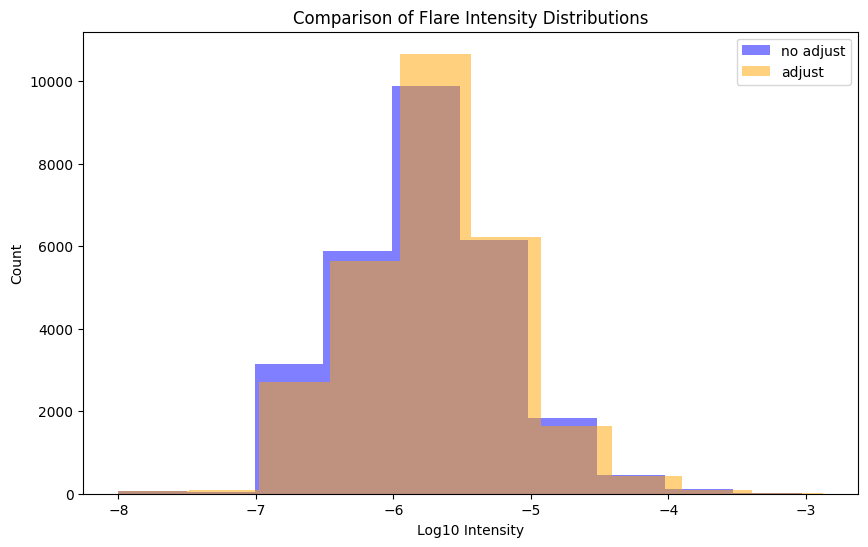

In [82]:
plt.figure(figsize=(10,6))
plt.hist(ftp['log_intensity'], alpha=0.5, label='no adjust', color='blue')
plt.hist(ftp['adjusted_log_intensity'], alpha=0.5, label='adjust', color='orange')
plt.xlabel('Log10 Intensity')
plt.ylabel('Count')
plt.legend()
plt.title('Comparison of Flare Intensity Distributions')

In [178]:
def flare_matching(one_df, another_df, tol_peak = "20min", log_intensity_tol = 0.5, using_adjusted_intensity=True):
    matched_id = [] # the start time of the matched flare in another_df
    duplicate_match = 0
    for i in range(one_df.shape[0]):
        flare = one_df.iloc[i]
        peak_time = flare['peak_time']
        
        # first matching by peak time
        matched_flare = another_df[(another_df['peak_time'] >= peak_time - pd.Timedelta(tol_peak)) & (another_df['peak_time'] <= peak_time + pd.Timedelta(tol_peak))]
        # then by log intensity
        if matched_flare.shape[0] == 0:
            matched_id.append(None)
            continue
        else:
            # match with log intensity +- xx
            logintensity = flare['log_intensity']
            if using_adjusted_intensity:
                matched_flare = matched_flare[(matched_flare['adjusted_log_intensity'] >= logintensity - log_intensity_tol) & (matched_flare['adjusted_log_intensity'] <= logintensity + log_intensity_tol)]
            else:
                matched_flare = matched_flare[(matched_flare['log_intensity'] >= logintensity - log_intensity_tol) & (matched_flare['log_intensity'] <= logintensity + log_intensity_tol)]
            if matched_flare.shape[0] == 0:
                matched_id.append(None)
            elif matched_flare.shape[0] == 1:
                matched_id.append(matched_flare['start_time'].values[0])
            else:
                #print(matched_flare.shape[0])
                duplicate_match += 1
                # choose the flare with the nearest peak time
                try:
                    matched_flare['closed_time'] = matched_flare['peak_time'].apply(lambda x: x - peak_time)
                    matched_flare = matched_flare.sort_values(by='closed_time', ascending=True)
                    matched_id.append(matched_flare['start_time'].values[0])
                except:
                    print(matched_flare)
                    matched_id.append(matched_flare['start_time'].values[0])
                
    print("Duplicate match: ", duplicate_match)
    return matched_id

In [57]:
def flare_matching(
    one_df: pd.DataFrame,
    another_df: pd.DataFrame,
    another_df_name: str,
    tol_peak: str = "20min",
    log_intensity_tol: float = 0.5,
    using_adjusted_intensity: bool = True,
):
    """
    For each flare in one_df, find a matching flare in another_df such that:
      - peak_time is within ± tol_peak (nearest in time is chosen), and
      - intensity differs by at most log_intensity_tol
        (using adjusted_log_intensity or log_intensity as specified).

    Returns
    -------
    matched_id : list
        List of matched start_time from another_df (or None if no match).
    """

    # Work on copies to avoid touching originals
    left = one_df.copy().reset_index().rename(columns={"index": "_orig_idx"})
    right = another_df.copy()

    # Ensure peak_time is datetime
    left["peak_time"] = pd.to_datetime(left["peak_time"])
    right["peak_time"] = pd.to_datetime(right["peak_time"])

    # Choose which intensity column to use on the right side
    if using_adjusted_intensity:
        if "adjusted_log_intensity" not in right.columns:
            raise KeyError("Column 'adjusted_log_intensity' not found in another_df")
        right["intensity_match"] = right["adjusted_log_intensity"]
    else:
        if "log_intensity" not in right.columns:
            raise KeyError("Column 'log_intensity' not found in another_df")
        right["intensity_match"] = right["log_intensity"]

    # Sort by time for merge_asof
    left = left.sort_values("peak_time")
    right = right.sort_values("peak_time")

    # Merge on nearest peak_time within tolerance
    merged = pd.merge_asof(
        left,
        right[["peak_time", "start_time", "intensity_match", "noaa_ar"]],
        on="peak_time",
        direction="nearest",
        tolerance=pd.Timedelta(tol_peak),
        suffixes=("", f"_{another_df_name}"),
    )
    #print(merged.columns)

    # Now enforce the intensity tolerance
    # (if no flare was matched in time, start_time is NaN and we keep it as None)
    if "log_intensity" not in merged.columns:
        raise KeyError("Column 'log_intensity' not found in one_df")

    delta_intensity = (merged["intensity_match"] - merged["log_intensity"]).abs()
    ok_match = merged[f"start_time_{another_df_name}"].notna() & (delta_intensity <= log_intensity_tol)

    # Keep rows where both time & intensity conditions hold; otherwise None
    merged.loc[~ok_match, [f"start_time_{another_df_name}", "intensity_match",
                           "peak_time", "noaa_ar"]] = None
    

    # Restore original order
    merged = merged.set_index("_orig_idx").sort_index()
    merged = merged.rename(columns={"noaa_ar": f"noaa_ar_{another_df_name}"})

    mmatched_portion = merged[merged[f"start_time_{another_df_name}"].notna()].shape[0] / merged.shape[0]
    return merged, mmatched_portion


In [28]:
ftp.columns

Index(['Unnamed: 0', 'start_time', 'peak_time', 'end_time', 'label', 'noaa_ar',
       'obs', 'cls', 'log_intensity', 'adjusted_log_intensity'],
      dtype='object')

In [29]:
sci.columns

Index(['start_time', 'end_time', 'peak_time', 'label', 'id', 'hg1', 'hg2',
       'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2', 'solar_p_angle',
       'solar_radius', 'cls', 'log_intensity'],
      dtype='object')

In [37]:
sci_ftp_matched = flare_matching(sci, ftp, tol_peak="20min", log_intensity_tol=0.5, using_adjusted_intensity=True, another_df_name="ftp")

Index(['_orig_idx', 'start_time', 'end_time', 'peak_time', 'label', 'id',
       'hg1', 'hg2', 'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2',
       'solar_p_angle', 'solar_radius', 'cls', 'log_intensity',
       'start_time_ftp', 'intensity_match', 'noaa_ar'],
      dtype='object')


In [45]:
sci_ftp_matched['start_time_ftp'].notna().sum() / len(sci)

np.float64(0.7594159265392142)

In [40]:
# proof that SSW also applies the 0.7 correction before 2019-12-07

sci_ssw_matched = flare_matching(sci, ssw, tol_peak="1min", log_intensity_tol=3, using_adjusted_intensity=False, another_df_name="ssw")

Index(['_orig_idx', 'start_time', 'end_time', 'peak_time', 'label', 'id',
       'hg1', 'hg2', 'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2',
       'solar_p_angle', 'solar_radius', 'cls', 'log_intensity',
       'start_time_ssw', 'intensity_match', 'noaa_ar'],
      dtype='object')


In [41]:
len(sci_ssw_matched), len(sci)

(33215, 33215)

In [43]:
sci_ssw_matched['start_time_ssw'].notna().sum() / len(sci)

np.float64(0.6530182146620502)

In [48]:
sci_ssw_matched['log_diff'] = sci_ssw_matched['log_intensity'] - sci_ssw_matched['intensity_match']

In [50]:
before_20191207_diff = sci_ssw_matched[sci_ssw_matched['start_time'] < '2019-12-07']['log_diff']
after_20191207_diff = sci_ssw_matched[sci_ssw_matched['start_time'] >= '2019-12-07']['log_diff']

In [51]:
before_20191207_diff = np.abs(before_20191207_diff)
after_20191207_diff = np.abs(after_20191207_diff)

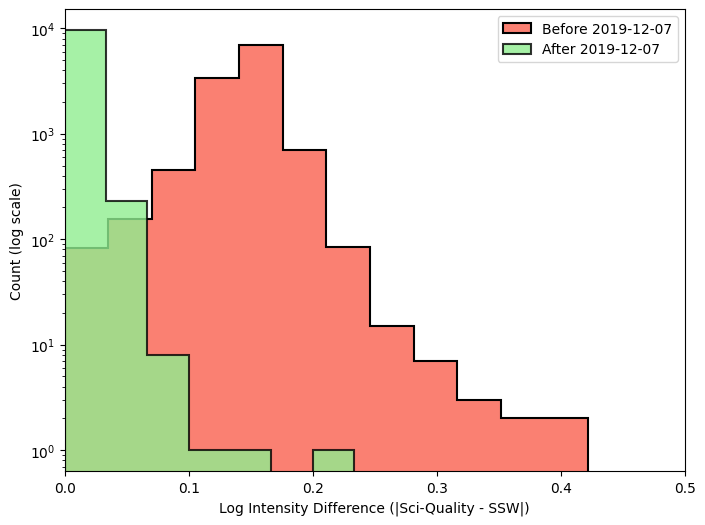

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(before_20191207_diff.dropna(), bins=30, alpha=1, label='Before 2019-12-07', 
         histtype='stepfilled', edgecolor='black', facecolor='salmon', linewidth=1.5)
plt.hist(after_20191207_diff.dropna(), bins=30, alpha=0.8, label='After 2019-12-07', 
         histtype='stepfilled', edgecolor='black', facecolor='lightgreen', linewidth=1.5)
plt.xlim(0, 0.5)
plt.yscale('log')
plt.xlabel('Log Intensity Difference (|Sci-Quality - SSW|)', fontsize=10)
plt.ylabel('Count (log scale)', fontsize=10)
plt.legend(fontsize=10)
plt.savefig('./figures/sci_ssw_log_intensity_difference.pdf', dpi=300)


In [53]:
tol_peak_list = ["1min", "3min", "6min", "9min", "12min", 
                 "15min", "18min", "21min", "24min", "27min"]
tol_logintensity_list = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

In [72]:
def matched_percentage(one_df, another_df, using_adjusted_intensity=True):
    another_df_name = "temp"
    proportions = []
    for tol_peak in tol_peak_list:
        for tol_logintensity in tol_logintensity_list:
            print(f"Processing tol_peak: {tol_peak}, tol_logintensity: {tol_logintensity}")
            _, portion = flare_matching(one_df, another_df, tol_peak=tol_peak, log_intensity_tol=tol_logintensity, another_df_name=another_df_name, using_adjusted_intensity=using_adjusted_intensity)
            print("Proportion matched: ", portion)
            proportions.append(portion)
    return proportions

In [62]:
sci_ftp_proportions = matched_percentage(sci, ftp)

Processing tol_peak: 1min, tol_logintensity: 0.05
Proportion matched:  0.667048020472678
Processing tol_peak: 1min, tol_logintensity: 0.1
Proportion matched:  0.6910733102513924
Processing tol_peak: 1min, tol_logintensity: 0.3
Proportion matched:  0.6967334035827186
Processing tol_peak: 1min, tol_logintensity: 0.5
Proportion matched:  0.6967334035827186
Processing tol_peak: 1min, tol_logintensity: 0.7
Proportion matched:  0.6967334035827186
Processing tol_peak: 1min, tol_logintensity: 0.9
Proportion matched:  0.6967334035827186
Processing tol_peak: 3min, tol_logintensity: 0.05
Proportion matched:  0.6688243263585729
Processing tol_peak: 3min, tol_logintensity: 0.1
Proportion matched:  0.6932410055697726
Processing tol_peak: 3min, tol_logintensity: 0.3
Proportion matched:  0.6991419539364745
Processing tol_peak: 3min, tol_logintensity: 0.5
Proportion matched:  0.6991419539364745
Processing tol_peak: 3min, tol_logintensity: 0.7
Proportion matched:  0.6991419539364745
Processing tol_peak:

In [64]:
sci_ssw_proportions = matched_percentage(sci, ssw)

Processing tol_peak: 1min, tol_logintensity: 0.05
Proportion matched:  0.6274273671533945
Processing tol_peak: 1min, tol_logintensity: 0.1
Proportion matched:  0.6468764112599729
Processing tol_peak: 1min, tol_logintensity: 0.3
Proportion matched:  0.6527773596266747
Processing tol_peak: 1min, tol_logintensity: 0.5
Proportion matched:  0.6528074665060967
Processing tol_peak: 1min, tol_logintensity: 0.7
Proportion matched:  0.6528676802649406
Processing tol_peak: 1min, tol_logintensity: 0.9
Proportion matched:  0.6528977871443625
Processing tol_peak: 3min, tol_logintensity: 0.05
Proportion matched:  0.635225048923679
Processing tol_peak: 3min, tol_logintensity: 0.1
Proportion matched:  0.6554267650158061
Processing tol_peak: 3min, tol_logintensity: 0.3
Proportion matched:  0.6616287821767274
Processing tol_peak: 3min, tol_logintensity: 0.5
Proportion matched:  0.6616588890561493
Processing tol_peak: 3min, tol_logintensity: 0.7
Proportion matched:  0.6617191028149932
Processing tol_peak:

In [73]:
ssw_ftp_proportions = matched_percentage(ssw, ftp, using_adjusted_intensity=False)

Processing tol_peak: 1min, tol_logintensity: 0.05
Proportion matched:  0.7560691570366389
Processing tol_peak: 1min, tol_logintensity: 0.1
Proportion matched:  0.7566066469587028
Processing tol_peak: 1min, tol_logintensity: 0.3
Proportion matched:  0.7569052524709606
Processing tol_peak: 1min, tol_logintensity: 0.5
Proportion matched:  0.7569649735734122
Processing tol_peak: 1min, tol_logintensity: 0.7
Proportion matched:  0.756994834124638
Processing tol_peak: 1min, tol_logintensity: 0.9
Proportion matched:  0.756994834124638
Processing tol_peak: 3min, tol_logintensity: 0.05
Proportion matched:  0.7628773627161157
Processing tol_peak: 3min, tol_logintensity: 0.1
Proportion matched:  0.7634745737406312
Processing tol_peak: 3min, tol_logintensity: 0.3
Proportion matched:  0.7638030398041148
Processing tol_peak: 3min, tol_logintensity: 0.5
Proportion matched:  0.7638627609065664
Processing tol_peak: 3min, tol_logintensity: 0.7
Proportion matched:  0.7638926214577921
Processing tol_peak: 

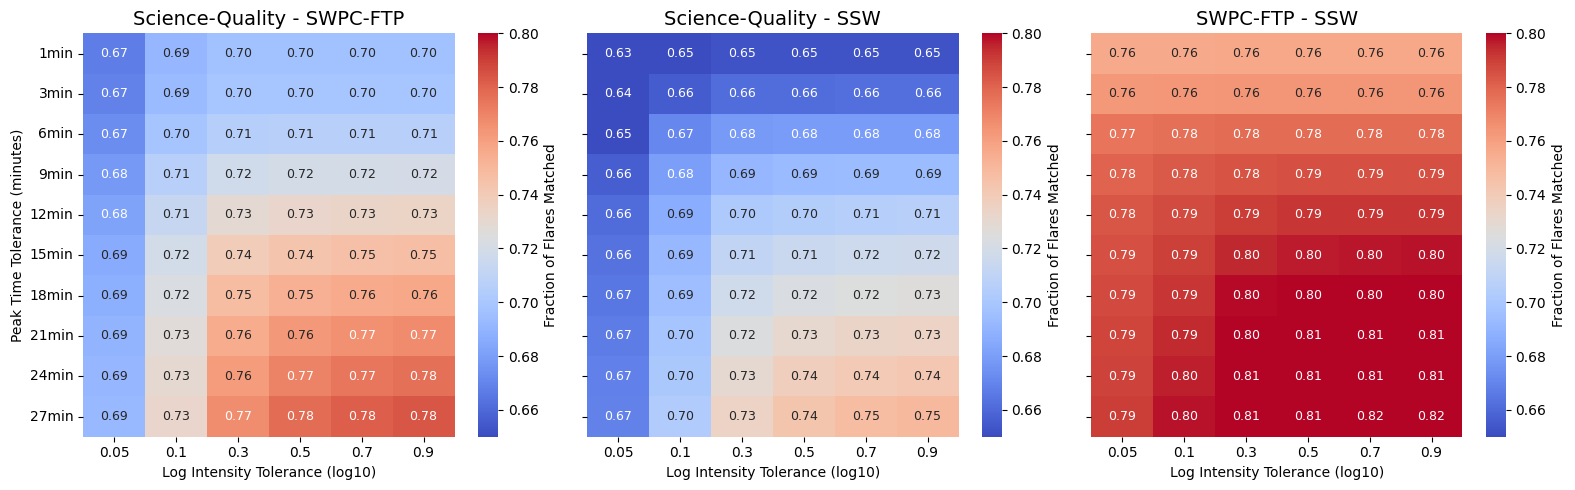

In [149]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

titles = ["Science-Quality - SWPC-FTP",
          "Science-Quality - SSW",
          "SWPC-FTP - SSW"]

prop_mats = [sci_ftp_proportions, sci_ssw_proportions, ssw_ftp_proportions]  

for ax, mat, title in zip(axes, prop_mats, titles):
    df = np.array(mat).reshape(len(tol_peak_list), len(tol_logintensity_list))
    df = pd.DataFrame(df, index=tol_peak_list, columns=tol_logintensity_list)
    sns.heatmap(df, annot=True, fmt=".2f",
                cmap="coolwarm", vmin=0.65, vmax=0.8,
                cbar_kws={'label': 'Fraction of Flares Matched'},
                ax=ax, annot_kws={"size": 9})
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Log Intensity Tolerance (log10)")
axes[0].set_ylabel("Peak Time Tolerance (minutes)")

plt.tight_layout()
plt.savefig("./figures/flare_matching_comparison_heatmaps.pdf", dpi=300)
plt.show()


In [91]:
# 15 min, 0.3
sci_ftp_ssw, _ = flare_matching(sci, ftp, tol_peak="15min", log_intensity_tol=0.3, using_adjusted_intensity=True, another_df_name="ftp")
sci_ssw, _ = flare_matching(sci, ssw, tol_peak="15min", log_intensity_tol=0.3, using_adjusted_intensity=True, another_df_name="ssw")

In [92]:
sci_ftp_ssw.columns

Index(['start_time', 'end_time', 'peak_time', 'label', 'id', 'hg1', 'hg2',
       'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2', 'solar_p_angle',
       'solar_radius', 'cls', 'log_intensity', 'start_time_ftp',
       'intensity_match', 'noaa_ar_ftp'],
      dtype='object')

In [93]:
sci_ssw.columns

Index(['start_time', 'end_time', 'peak_time', 'label', 'id', 'hg1', 'hg2',
       'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2', 'solar_p_angle',
       'solar_radius', 'cls', 'log_intensity', 'start_time_ssw',
       'intensity_match', 'noaa_ar_ssw'],
      dtype='object')

In [94]:
sci_ftp_ssw[['start_time_ssw', 'noaa_ar_ssw', 'intensity_match_ssw']] = sci_ssw[['start_time_ssw', 'noaa_ar_ssw', 'intensity_match']]

In [98]:
sci_ftp_ssw.columns

Index(['start_time', 'end_time', 'peak_time', 'label', 'id', 'hg1', 'hg2',
       'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2', 'solar_p_angle',
       'solar_radius', 'cls', 'log_intensity', 'start_time_ftp',
       'intensity_match', 'noaa_ar_ftp', 'start_time_ssw', 'noaa_ar_ssw',
       'intensity_match_ssw'],
      dtype='object')

In [95]:
sci_ftp_ssw.shape[0], sci_ftp_ssw['start_time_ftp'].notna().sum(), sci_ftp_ssw['start_time_ssw'].notna().sum()

(33215, np.int64(24562), np.int64(23611))

In [96]:
sci_ftp_ssw[ sci_ftp_ssw['start_time_ftp'].notna() & sci_ftp_ssw['start_time_ssw'].notna()].shape[0]

22759

In [97]:
22759 / len(sci_ftp_ssw)

0.6852024687641126

In [100]:
!pip3 install matplotlib_venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=618260f96a59d03cfc4e37415636e38533676b1822232ec7fcb48c28d3614565
  Stored in directory: c:\users\huke0\appdata\local\pip\cache\wheels\d1\5f\e6\771479559f992b8398265ebf61f8a3d33ca0b8f75552e06ad2
Successfully built matplotlib_venn


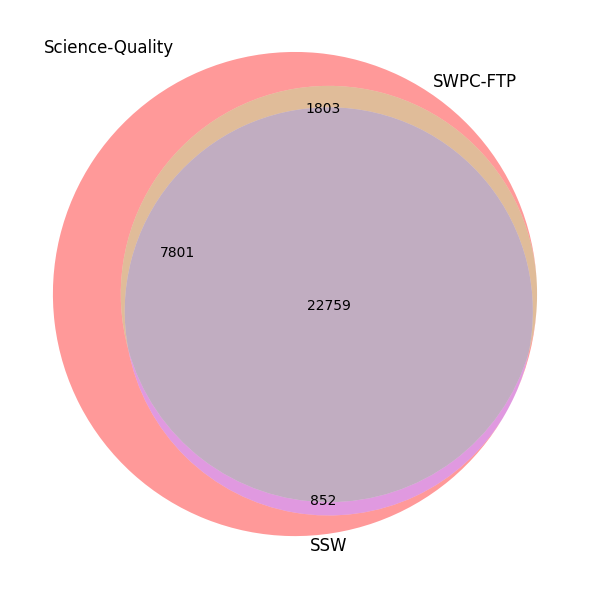

In [102]:
# vein plot

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

df = sci_ftp_ssw

# Membership flags: every row is a Science-quality flare by construction
S = df['start_time'].notna()                     # Science-quality
F = df['start_time_ftp'].notna()        # has SWPC-FTP match
W = df['start_time_ssw'].notna()        # has SSW match

# Counts for each region (S = science, F = ftp, W = ssw)
n_S_only      = ((S) & (~F) & (~W)).sum()
n_F_only      = ((F) & (~S) & (~W)).sum()   # likely 0 if df is science-based
n_W_only      = ((W) & (~S) & (~F)).sum()   # likely 0 if df is science-based
n_SF_only     = ((S) & (F) & (~W)).sum()
n_SW_only     = ((S) & (~F) & (W)).sum()
n_FW_only     = ((~S) & (F) & (W)).sum()    # usually 0 here as well
n_SFW         = ((S) & (F) & (W)).sum()

subsets = (n_S_only, n_F_only, n_SF_only,
           n_W_only, n_SW_only, n_FW_only, n_SFW)

plt.figure(figsize=(6, 6))
venn3(
    subsets=subsets,
    set_labels=("Science-Quality", "SWPC-FTP", "SSW")
)
#plt.title("Overlap between Science-Quality, SWPC-FTP, and SSW flare lists\n(over merged portion)")
plt.tight_layout()
plt.show()



In [109]:
sci_ftp_ssw_double_verified['noaa_ar_ssw']

_orig_idx
1        11039
2        11039
7        11039
11       11039
12       11039
         ...  
33210    13936
33211    13936
33212    13941
33213    13936
33214    13939
Name: noaa_ar_ssw, Length: 22759, dtype: object

In [111]:
# for the double veried matches, compare their noaa_ar labels
sci_ftp_ssw_double_verified = sci_ftp_ssw[ S & F & W ]
ar_diff = sci_ftp_ssw_double_verified['noaa_ar_ftp'] - sci_ftp_ssw_double_verified['noaa_ar_ssw'].astype(int)

In [115]:
ar_diff[ar_diff != 0].value_counts()

-1.0        324
-2.0        305
 1.0        270
 2.0        219
-3.0        191
           ... 
-12595.0      1
-12589.0      1
-12585.0      1
-12583.0      1
 13917.0      1
Name: count, Length: 1349, dtype: int64

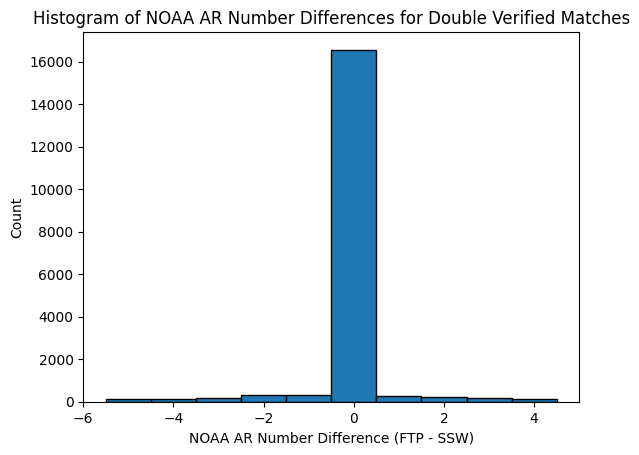

In [113]:
plt.hist(ar_diff, bins=np.arange(-5, 6)-0.5, edgecolor='black')
plt.xlabel('NOAA AR Number Difference (FTP - SSW)')
plt.ylabel('Count')
plt.title('Histogram of NOAA AR Number Differences for Double Verified Matches')
plt.show()

In [116]:
not_matched = sci_ftp_ssw[(S) & (~F) & (~W)]

In [120]:
not_matched.shape

(7801, 23)

In [119]:
not_matched[(not_matched['hg1'] < 9999) & (not_matched['hg1'] > -9999)]

,start_time,end_time,peak_time,label,id,hg1,hg2,car1,car2,rtheta1,...,solar_p_angle,solar_radius,cls,log_intensity,start_time_ftp,intensity_match,noaa_ar_ftp,start_time_ssw,noaa_ar_ssw,intensity_match_ssw
_orig_idx,,,,,,,,,,,,,,,,,,,,,
20220,2017-02-09 02:55:00,NaN,NaT,B3.9,201702090255,348.102630,8.832396,316.48108,8.832396,0.333972,...,-15.377243,972.25476,B,-6.408935,NaT,NaN,NaN,NaT,None,NaN
20234,2017-02-09 12:34:00,2017-02-09 12:48:00,NaT,B1.7,201702091234,319.403720,9.615508,282.46950,9.615508,0.691500,...,-15.524885,972.18616,B,-6.769551,NaT,NaN,NaN,NaT,None,NaN
20236,2017-02-12 18:31:00,2017-02-12 18:45:00,NaT,B1.3,201702121831,351.182300,29.744722,271.46252,29.744722,0.610343,...,-16.680939,971.60250,B,-6.886057,NaT,NaN,NaN,NaT,None,NaN
20241,2017-02-17 23:14:00,2017-02-17 23:45:00,NaT,B1.3,201702172314,306.839700,41.226635,158.65398,41.226635,0.931485,...,-18.409681,970.56420,B,-6.886057,NaT,NaN,NaN,NaT,None,NaN
20246,2017-02-19 17:20:00,2017-02-19 17:32:00,NaT,B2.8,201702191720,302.856720,-13.728762,131.63454,-13.728762,0.835960,...,-18.956774,970.19147,B,-6.552842,NaT,NaN,NaN,NaT,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31359,2024-06-20 22:48:00,NaN,NaT,C4.3,202406202248,48.620327,-27.352514,167.04568,-27.352514,0.821827,...,-7.002777,943.93915,C,-5.366532,NaT,NaN,NaN,NaT,None,NaN
31403,2024-06-24 21:23:00,2024-06-24 21:41:00,NaT,C5.3,202406242123,284.106000,-21.440191,350.36377,-21.440191,0.978080,...,-5.246037,943.72485,C,-5.275724,NaT,NaN,NaN,NaT,None,NaN
31404,2024-06-25 06:09:00,2024-06-25 06:35:00,NaT,C4.9,202406250609,59.653732,-10.925148,121.05794,-10.925148,0.874653,...,-5.081623,943.70734,C,-5.309804,NaT,NaN,NaN,NaT,None,NaN


In [124]:
not_matched['year'] = not_matched['start_time'].dt.year

C:\Users\huke0\AppData\Local\Temp\ipykernel_11748\2523777556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_matched['year'] = not_matched['start_time'].dt.year


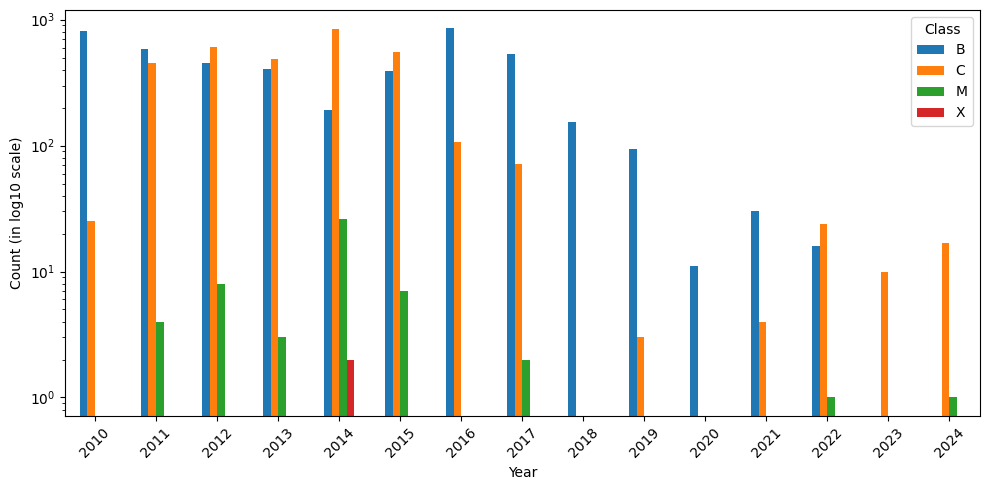

In [150]:
count_df = not_matched.groupby(['year', 'cls']).size().unstack(fill_value=0)

count_df.plot(kind='bar', figsize=(10, 5))
#plt.title("Not-Matched Flare Counts by Year and Class")
plt.yscale('log')
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=45)
plt.ylabel("Count (in log10 scale)")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig("./figures/not_matched_sci_by_year_and_class.pdf", dpi=300)
plt.show()

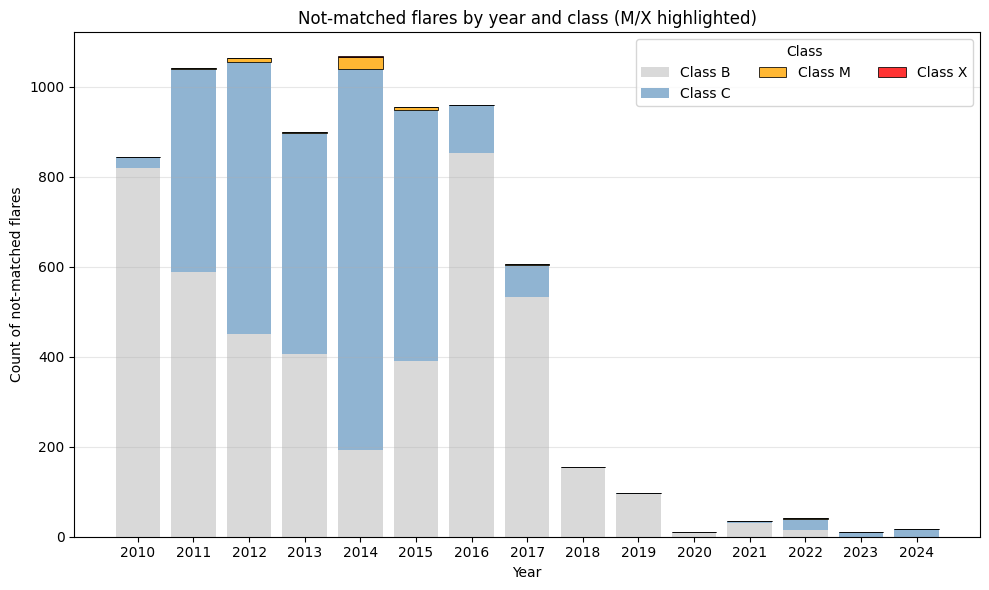

In [144]:
# counts_df: rows = years, columns = flare classes
counts_df = not_matched.groupby(['year', 'cls']).size().unstack(fill_value=0)

# Order classes so M/X are on top
class_order = ['A', 'B', 'C', 'M', 'X']
class_order = [c for c in class_order if c in counts_df.columns]  # keep only existing
counts_df = counts_df[class_order]

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
bottom = np.zeros(len(counts_df))
x = np.arange(len(counts_df.index))

colors = {
    'A': 'lightgrey',
    'B': 'silver',
    'C': 'steelblue',
    'M': 'orange',
    'X': 'red',
}

for cls in class_order:
    vals = counts_df[cls].values
    ax.bar(
        x,
        vals,
        bottom=bottom,
        label=f'Class {cls}',
        color=colors.get(cls, None),
        alpha=0.8 if cls in ['M', 'X'] else 0.6,
        edgecolor='black' if cls in ['M', 'X'] else 'none',
        linewidth=0.7 if cls in ['M', 'X'] else 0,
    )
    bottom += vals



ax.set_xticks(x)
ax.set_xticklabels(counts_df.index)
ax.set_xlabel('Year')
ax.set_ylabel('Count of not-matched flares')
ax.set_title('Not-matched flares by year and class (M/X highlighted)')
ax.legend(title='Class', ncol=3)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



<BarContainer object of 15 artists>

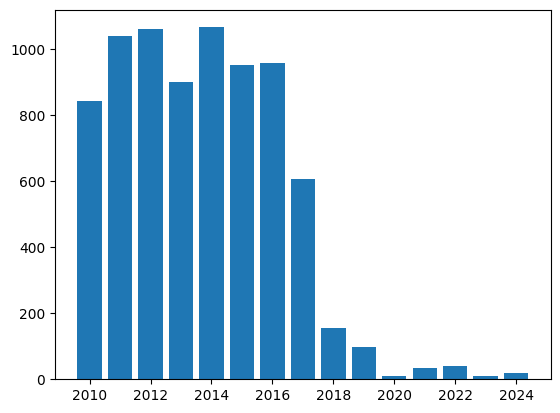

In [127]:
plt.bar(not_matched['year'].value_counts().index.sort_values(),
        not_matched['year'].value_counts().sort_index())

In [128]:
ftp[ftp['noaa_ar'] > 0].shape[0] / len(ftp)

0.8397317382635491

In [133]:
ftp[ftp['noaa_ar'] > 0].shape[0]

23164

In [131]:
(sci_ftp_ssw_double_verified[sci_ftp_ssw_double_verified['noaa_ar_ftp'] >0].shape[0]  + 583)/ len(sci_ftp_ssw)

0.6001204275176878

In [132]:
sci_ftp_ssw_double_verified[sci_ftp_ssw_double_verified['noaa_ar_ftp'] >0].shape[0]  + 583

19933

In [130]:
sci_ftp_ssw_double_verified[sci_ftp_ssw_double_verified['noaa_ar_ftp'] >0].shape[0] / len(sci_ftp_ssw_double_verified)

0.8502131025088976

In [153]:
sci_ftp_ssw.columns

Index(['start_time', 'end_time', 'peak_time', 'label', 'id', 'hg1', 'hg2',
       'car1', 'car2', 'rtheta1', 'rtheta2', 'xy1', 'xy2', 'solar_p_angle',
       'solar_radius', 'cls', 'log_intensity', 'start_time_ftp',
       'intensity_match', 'noaa_ar_ftp', 'start_time_ssw', 'noaa_ar_ssw',
       'intensity_match_ssw'],
      dtype='object')

In [156]:
sci_ftp_ssw[(sci_ftp_ssw['xy1']>-9999) & (sci_ftp_ssw['xy1']<9999)].shape[0]/ sci_ftp_ssw[sci_ftp_ssw['xy1'].notna()].shape[0]

0.9981103850090544

In [306]:
sci_ftp_ssw[(sci_ftp_ssw['start_time_ftp'].isna()) | (sci_ftp_ssw['noaa_ar_ftp'] == 0)].shape[0] / sci_ftp_ssw.shape[0]

0.37326509107331024

In [157]:
srs_2010_2024 = pd.read_csv("D:\\2024_S1\\ML_SEP_2402\\swpc_SRS\\SRS_noaa_2010_2024_hpc.csv")

In [303]:
srs_2010_2024

,Date,NOAA_AR,Location,ar_Latitude,ar_Longitude,hpc_x,hpc_y
0,2009-12-31,11039,S28W21,-28.0,21.0,309.908727,-418.524484
1,2010-01-01,11039,S27W35,-27.0,35.0,500.327603,-406.356793
2,2010-01-02,11039,S28W46,-28.0,46.0,621.468261,-425.977880
3,2010-01-03,11039,S29W59,-29.0,59.0,733.000760,-448.365774
4,2010-01-04,11039,S28W72,-28.0,72.0,820.340467,-442.247361
...,...,...,...,...,...,...,...
20550,2024-12-30,13938,N20W14,20.0,14.0,222.688260,378.126220
20551,2024-12-30,13939,S17E06,-17.0,-6.0,-97.951708,-240.774802
20552,2024-12-30,13941,S06E14,-6.0,-14.0,-235.765528,-56.263257
20553,2024-12-30,13942,S13E40,-13.0,-40.0,-613.116512,-184.370189


In [194]:
srs_2010_2024['Date'] = pd.to_datetime(srs_2010_2024['Date'], format='%Y-%m-%d')

In [212]:
# drop nan rows
srs_2010_2024 = srs_2010_2024.dropna(subset=['hpc_x', 'hpc_y']).reset_index(drop=True)

In [220]:
def find_ar(flare_hpc_x, flare_hpc_y, flare_peak_time):
    if not np.isnan(flare_hpc_x) and not np.isnan(flare_hpc_y):
        if flare_hpc_x > -1000 and flare_hpc_y > -1000:
            srs_sub = srs_2010_2024[srs_2010_2024['Date'].dt.strftime("%Y-%m-%d") == str(flare_peak_time.date())]
            if srs_sub.shape[0] > 0:
                distances = np.sqrt((srs_sub['hpc_x'] - flare_hpc_x)**2 + (srs_sub['hpc_y'] - flare_hpc_y)**2)
                min_distance = np.min(distances)
                nearest_ar = srs_sub[distances == min_distance]['NOAA_AR'].values[0]
                return nearest_ar, min_distance
            else:
                print("No AR infor for this date: ", flare_peak_time)
                return np.nan, np.nan
        else:
            print("Invalid flare location")
            return np.nan, np.nan
    else:
        return np.nan, np.nan

In [163]:
sci_ftp_ssw.loc[sci_ftp_ssw['peak_time'].isna(), 'peak_time'] = sci.loc[sci_ftp_ssw['peak_time'].isna(), 'peak_time']

In [221]:
sci_ftp_ssw['nearest_ar'] = np.nan
sci_ftp_ssw['nearest_ar_distance'] = np.nan
sci_ftp_ssw['nearest_ar'], sci_ftp_ssw['nearest_ar_distance'] = zip(*sci_ftp_ssw.apply(lambda x: find_ar(x['xy1'], x['xy2'], x['peak_time']), axis=1))

Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
Invalid flare location
No AR infor for this date:  2017-03-04 01:40:00
No AR infor for this date:  2017-03-04 01:47:00
No AR infor for this date:  2017-03-04 04:50:00
No AR infor for this date:  2017-03-04 05:07:00
No AR infor for this date:  2017-03-04 10:18:00
No AR infor for this date:  2017-03-04 23:00:00
Invalid flare location
Invalid flare location
Invalid flare location
No AR infor for this date:  2017-03-06 12:04:00
No AR infor for this date:  2017-03-06 14:21:00
Invalid flare location
No AR infor for this date:  2017-03-08 14

In [224]:
withlocations = sci_ftp_ssw[~sci_ftp_ssw['xy1'].isnull()]

In [307]:
withlocations[~withlocations['nearest_ar'].isnull()].shape[0]

11783

In [225]:
withlocations[~withlocations['nearest_ar'].isnull()].shape[0] / withlocations.shape[0]

0.927722226596331

In [226]:
withlocations[~withlocations['nearest_ar'].isnull()]['nearest_ar_distance'].describe()

count    11783.000000
mean       230.233250
std        356.733273
min          1.505446
25%         70.701257
50%        128.780106
75%        254.371000
max      13080.242419
Name: nearest_ar_distance, dtype: float64

In [227]:
# the original length of the flare list
withlocations.shape[0]

12701

In [228]:
# the length of the flare list with valid hpc locations
withlocations[(withlocations['xy1'] > -1000) & (withlocations['xy2'] > -1000)].shape[0], 10812/withlocations.shape[0]

(12083, 0.8512715534209905)

In [231]:
# the length of the flare list with matched ftp
withlocations[~withlocations['start_time_ftp'].isnull()].shape[0], 11472/withlocations.shape[0]

(11472, 0.9032359656719944)

In [233]:
# the length of the flare list with matched ssw
withlocations[~withlocations['start_time_ssw'].isnull()].shape[0], 11178/withlocations.shape[0]

(11178, 0.8800881820329108)

In [236]:
# Consider assign the not matched sci flares and ftp_noaa_ar == 0 flares to the nearest AR
# Check Credibility of the nearest AR

# 1. For the flares with valid hpc locations, 69.5% of them have the same nearest_ar as the ftp_noaa_ar
withlocations[(~withlocations['nearest_ar'].isnull()) & (~withlocations['start_time_ftp'].isnull())& (withlocations['noaa_ar_ftp'] != 0) & (withlocations['nearest_ar'] == withlocations['noaa_ar_ftp'])].shape[0] / withlocations[(~withlocations['nearest_ar'].isnull()) & (~withlocations['start_time_ftp'].isnull()) & (withlocations['noaa_ar_ftp'] != 0)].shape[0]

0.6952109102442119

In [237]:
# details
arnum_diff = withlocations[(~withlocations['nearest_ar'].isnull()) & (~withlocations['start_time_ftp'].isnull())& (withlocations['noaa_ar_ftp'] != 0)]['nearest_ar'] - withlocations[(~withlocations['nearest_ar'].isnull()) & (~withlocations['start_time_ftp'].isnull())& (withlocations['noaa_ar_ftp'] != 0)]['noaa_ar_ftp']
arnum_diff = np.abs(arnum_diff)
arnum_diff.describe()

count    9459.000000
mean        1.479860
std        13.242516
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       800.000000
dtype: float64

In [317]:
arnum_diff[arnum_diff <= 7].shape[0] / arnum_diff.shape[0]

0.9697642456919336

In [240]:
#!!!!!!!manually correct 16 obvious mistakes

for index in arnum_diff.sort_values(ascending=False)[:16].index:
    print(withlocations.loc[index][['noaa_ar_ssw', 'noaa_ar_ftp', 'nearest_ar']])
    withlocations.at[index, 'noaa_ar_ftp'] = withlocations.loc[index]['nearest_ar']

noaa_ar_ssw      12816
noaa_ar_ftp    12016.0
nearest_ar     12816.0
Name: 22827, dtype: object
noaa_ar_ssw      13395
noaa_ar_ftp    13995.0
nearest_ar     13380.0
Name: 28508, dtype: object
noaa_ar_ssw      13380
noaa_ar_ftp    13880.0
nearest_ar     13380.0
Name: 28470, dtype: object
noaa_ar_ssw      12965
noaa_ar_ftp    12695.0
nearest_ar     12965.0
Name: 24812, dtype: object
noaa_ar_ssw      13559
noaa_ar_ftp    13359.0
nearest_ar     13559.0
Name: 29842, dtype: object
noaa_ar_ssw      13564
noaa_ar_ftp    13364.0
nearest_ar     13564.0
Name: 29912, dtype: object
noaa_ar_ssw      12860
noaa_ar_ftp    12680.0
nearest_ar     12860.0
Name: 23539, dtype: object
noaa_ar_ssw      13539
noaa_ar_ftp    13359.0
nearest_ar     13539.0
Name: 29696, dtype: object
noaa_ar_ssw      13538
noaa_ar_ftp    13359.0
nearest_ar     13538.0
Name: 29697, dtype: object
noaa_ar_ssw      12860
noaa_ar_ftp    12680.0
nearest_ar     12859.0
Name: 23538, dtype: object
noaa_ar_ssw          0
noaa_ar_ftp    12

In [241]:
# Decide the treshold of the distance between the flare and the nearest AR to be considered as a match

distance_for_same_ar = withlocations[(~withlocations['nearest_ar'].isnull()) & (~withlocations['start_time_ftp'].isnull())& (withlocations['noaa_ar_ftp'] != 0) & (withlocations['nearest_ar'] == withlocations['noaa_ar_ftp'])]['nearest_ar_distance']

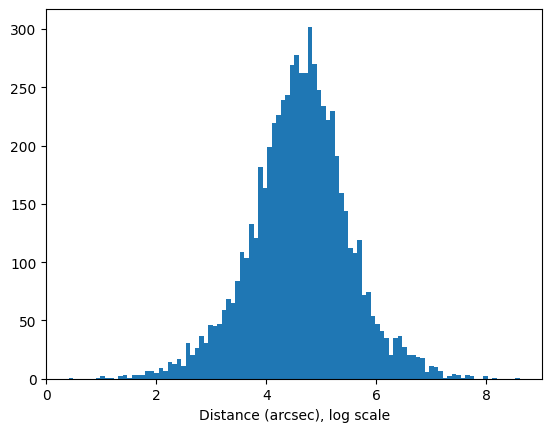

In [ ]:
plt.hist(np.log(distance_for_same_ar), bins=100)
#plt.title("Distance between flare and nearest AR when nearest AR is the same as noaa_ar_ftp")
plt.xlabel("Distance (arcsec), log scale")
plt.ylabel("Count")
plt.show()

In [318]:
(distance_for_same_ar).describe()
# mean 4.610372, std 0.895478

count    6592.000000
mean      151.423929
std       196.131500
min         1.505446
25%        59.268830
50%       102.639993
75%       174.007788
max      5452.386534
Name: nearest_ar_distance, dtype: float64

In [247]:
np.exp(np.mean(np.log(distance_for_same_ar)) + 1*np.std(np.log(distance_for_same_ar)))

np.float64(246.11085090314077)

In [250]:
np.quantile(distance_for_same_ar, 0.90), np.quantile(distance_for_same_ar, 0.95), np.quantile(distance_for_same_ar, 0.99)

(np.float64(290.98059872734143),
 np.float64(427.64321615516394),
 np.float64(923.8156414531227))

In [253]:
# set 250 as the threshold for the distance between the flare and the nearest AR to be considered as a match

def assign_ar_pattern1(row, threshold=250):
    # if the flare has matched ftp, and the ftp_noaa_ar is not 0
    # keep the ftp_noaa_ar
    if not np.isnan(row['noaa_ar_ftp']) and row['noaa_ar_ftp'] != 0:
        return row['noaa_ar_ftp']
    else:
        if row['nearest_ar_distance'] < threshold:
            return row['nearest_ar']
        else:
            return np.nan

In [254]:
withlocations['assigned_ar'] = withlocations.apply(lambda x: assign_ar_pattern1(x), axis=1)

C:\Users\huke0\AppData\Local\Temp\ipykernel_11748\684911175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  withlocations['assigned_ar'] = withlocations.apply(lambda x: assign_ar_pattern1(x), axis=1)


In [255]:
withlocations[~withlocations['assigned_ar'].isnull()].shape[0] / withlocations.shape[0]

0.8657586016849067

In [256]:
# 9% more flares are assigned to an AR

## Before 2017-02-19, no pinpoint location information for Sci-Qaulity data

In [257]:
withoutlocations = sci_ftp_ssw[sci_ftp_ssw['xy1'].isnull()]

In [258]:
withoutlocations.shape[0]

20514

In [260]:
# if we only use ssw_noaa_ar
withoutlocations[(~withoutlocations['start_time_ssw'].isnull())& (withoutlocations['noaa_ar_ssw'] != 0)].shape[0], 12433/withoutlocations.shape[0]

(12433, 0.6060739007507069)

In [262]:
# if we only use ftp_noaa_ar
withoutlocations[(~withoutlocations['start_time_ftp'].isnull()) & (withoutlocations['noaa_ar_ftp'] != 0)].shape[0], 10953/withoutlocations.shape[0]

(10953, 0.5339280491371746)

In [268]:
# Creditibility Check
# How different is the ssw_ar and ftp_ar?

(withoutlocations[(~withoutlocations['start_time_ftp'].isnull()) & (~withoutlocations['start_time_ssw'].isnull())]['noaa_ar_ftp'].astype(int) == withoutlocations[(~withoutlocations['start_time_ftp'].isnull()) & (~withoutlocations['start_time_ssw'].isnull())]['noaa_ar_ssw'].astype(int)).sum()

np.int64(8312)

In [269]:
8312 / withoutlocations[(~withoutlocations['start_time_ftp'].isnull()) & (~withoutlocations['start_time_ssw'].isnull())].shape[0]

0.698076761568825

In [270]:
nonsame = withoutlocations[(~withoutlocations['start_time_ftp'].isnull()) & (~withoutlocations['start_time_ssw'].isnull()) & (withoutlocations['noaa_ar_ftp'] != withoutlocations['noaa_ar_ssw'])]

<Axes: ylabel='Frequency'>

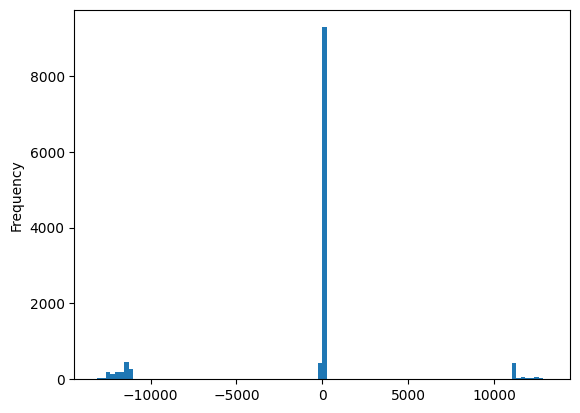

In [272]:
diff = nonsame['noaa_ar_ftp'].astype(int) - nonsame['noaa_ar_ssw'].astype(int)
(diff).plot.hist(bins=100)

In [273]:
diff[(diff > -10000) & (diff < 10000)].shape[0] / diff.shape[0]

0.8153187200806249

In [279]:
sci_ftp_ssw['noaa_ar_ssw'] = sci_ftp_ssw['noaa_ar_ssw'].astype(float)

In [292]:
withoutlocations['noaa_ar_ssw'] = withoutlocations['noaa_ar_ssw'].astype(float)

C:\Users\huke0\AppData\Local\Temp\ipykernel_11748\3624266039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  withoutlocations['noaa_ar_ssw'] = withoutlocations['noaa_ar_ssw'].astype(float)


In [291]:
for i in range(len(sci_ftp_ssw)):
    try:
        np.isnan(sci_ftp_ssw['noaa_ar_ssw'][i])
    except:
        print(i, sci_ftp_ssw['noaa_ar_ssw'][i])

In [293]:
def assign_ar_pattern2(row):
    # if any of the ftp_noaa_ar and ssw_noaa_ar is valid, keep the valid one, start with ftp_noaa_ar
    if not np.isnan(row['noaa_ar_ftp']) and row['noaa_ar_ftp'] != 0:
        return row['noaa_ar_ftp']
    elif not np.isnan(row['noaa_ar_ssw']) and row['noaa_ar_ssw'] != 0:
        return row['noaa_ar_ssw']
    else:
        return np.nan

In [294]:
withoutlocations['assigned_ar'] = withoutlocations.apply(lambda x: assign_ar_pattern2(x), axis=1)

C:\Users\huke0\AppData\Local\Temp\ipykernel_11748\1266730337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  withoutlocations['assigned_ar'] = withoutlocations.apply(lambda x: assign_ar_pattern2(x), axis=1)


In [295]:
withoutlocations['assigned_ar'].notnull().sum() / withoutlocations.shape[0]

np.float64(0.6304962464658282)

In [296]:
full_sci_with_assigned_ar = pd.concat([withlocations, withoutlocations], ignore_index=True)

In [298]:
full_sci_with_assigned_ar.shape[0], full_sci_with_assigned_ar['assigned_ar'].notnull().sum(), 23930/33215

(33215, np.int64(23930), 0.7204576245672136)

In [320]:
ftp[ftp['noaa_ar'] > 0].shape[0], 23164/len(ftp)

(23164, 0.8397317382635491)

In [327]:
36*3.56

128.16

In [300]:
full_sci_with_assigned_ar[(full_sci_with_assigned_ar['cls'] == 'X') & (full_sci_with_assigned_ar['assigned_ar'].isnull())].shape

(2, 26)

In [301]:
full_sci_with_assigned_ar[(full_sci_with_assigned_ar['cls'] == 'M') & (full_sci_with_assigned_ar['assigned_ar'].isnull())].shape

(108, 26)

In [302]:
full_sci_with_assigned_ar.to_csv("D:./Sci_matched_with_assigned_ar_20100101_20241231.csv", index=False)

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("D:./Sci_matched_with_assigned_ar_20100101_20241231.csv")

In [4]:
withlocations = df[~df['xy1'].isnull()]

In [5]:
withlocations[(withlocations['noaa_ar_ftp'].notnull()) & (withlocations['noaa_ar_ftp'] != 0)].shape[0] / withlocations.shape[0]

0.7766317612786395

In [8]:
withlocations[(withlocations['noaa_ar_ftp'].notnull()) & (withlocations['noaa_ar_ftp'] != 0)].shape[0]

9864

In [7]:
withlocations[~withlocations['assigned_ar'].isnull()].shape[0]

10996

In [9]:
(10996 - 9864) / 9864

0.11476074614760746